In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim

import torch_geometric
from torch_geometric.nn import knn_graph
from torch_geometric.loader import DataLoader

import numpy as np
import random
from sklearn.model_selection import train_test_split
import wandb

import gc

from segnn.segnn import SEGNN
from e3nn.o3 import Irreps, spherical_harmonics
from segnn.balanced_irreps import BalancedIrreps, WeightBalancedIrreps
from segnn.instance_norm import InstanceNorm
# from Utility_functions import Graph_datasetV2 as Graph_dataset

# use it for input features similar to hemodynamics paper
from Utility_functions import Graph_dataset_with_equiv_features, inlet_distance_mask, print_3D_graph, Graph_dataset_with_equiv_features, denormalize_predictions

import params

print('DATADIR', params.DATADIR)
print('NSIM', params.NSIM)
print('BATCH_SIZE', params.BATCH_SIZE)

print('python.__version__', sys.version_info)
print('torch.__version__', torch.__version__)
print('torch_geometric.__version__', torch_geometric.__version__)
print('torch.cuda.is_available()', torch.cuda.is_available())


DATADIR ../.data/Dataset_75sims
NSIM 75
BATCH_SIZE 1
python.__version__ sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
torch.__version__ 2.0.0
torch_geometric.__version__ 2.5.2
torch.cuda.is_available() True


In [2]:
a = Irreps('1o+2e+3x0e')
b = Irreps('4x1o+2o+2x1e')

c = Irreps()

In [3]:
print("PyTorch has version {}".format(torch.__version__))
print("The linked CUDA version is", torch.version.cuda)

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# dev = torch.device("cpu")
# torch.cuda.init()

print('Running on device:', dev)

PyTorch has version 2.0.0
The linked CUDA version is 11.8
Running on device: cuda:0


# Reproducibility seeds

In [4]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Hyperparameters

In [5]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
     
        {'epochs': params.EPOCHS,
         'batch_size': params.BATCH_SIZE,          
         'input_size' : params.INPUT_SIZE, 
         'edge_lmax' : params.EDGE_LMAX,
         'node_lmax' : params.NODE_LMAX,
         'hidden_lmax' : params.HIDDEN_LMAX,
         'num_layers' : params.NUM_LAYERS,
         'task' : params.TASK,
         'norm' : params.NORM,
         'output_size' : params.OUTPUT_SIZE,
         'hidden_size': params.HIDDEN_SIZE, 
         'neighbours' : params.NEIGHBOURS,
         'subsample_dataset': params.SUBSAMPLE_DATASET,
         'opt': params.OPT,
         'scheduler': params.SCHEDULER, 
         'learning_rate': params.LEARNING_RATE,
         'device': params.DEVICE,
         'early_stop' : params.EARLY_STOP}
    ]:
        args = objectview(args)

# **Dataset and dataloader**

In [6]:
# Dataset, change the root path accordingly
dataset = Graph_dataset_with_equiv_features(root = params.DATADIR)  #, inlet_mask = True)
test_sample = dataset[0]
print(test_sample.edge_index)

# 80-10-10 split

# first the dataset is split 80%-20%, with the first portion being the training set

if params.NSIM == 1:
    train_idx = list(range(1))
    val_test_idx = []
elif params.NSIM == 10:  # in this case the test_size cannot be smaller than 2
    train_idx, val_test_idx = train_test_split(range(len(dataset)), test_size = 0.2, shuffle = False)
else:
    train_idx, val_test_idx = train_test_split(range(len(dataset)), test_size = 0.1, shuffle = False)

print(train_idx)
print(val_test_idx)
# the 20% portion is split in half so to have two sets with 10% data each of the original dataset
if params.NSIM == 1:
    val_idx, test_idx = [], []
else:
    val_idx, test_idx = train_test_split(range(len(val_test_idx)), test_size = 0.5, shuffle = False)

# this line can be used to do training on a smaller subset of the training set
# if args.subsample_dataset != 1
train_idx = train_idx[:(len(train_idx))// args.subsample_dataset] 

train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]

# print(len(train_idx), len(val_idx), len(test_idx))
# print(len(train_idx) / len(dataset), len(val_idx) / len(dataset), len(test_idx) / len(dataset))

# torch_geometric DataLoaders are used for handling lists of graphs
n_works = 0
t_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=n_works)#, persistent_workers=True)
v_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=n_works)#, persistent_workers=True)

100%|██████████| 75/75 [00:00<?, ?it/s]

None
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
[67, 68, 69, 70, 71, 72, 73, 74]


# Test if graph is loaded correctly

In [7]:
name = 'SEGNN_model'
project = "SEGNN_CFD"

In [8]:

for sample in t_loader:
    break

print(t_loader.dataset[0].node_attr)


tensor([[0.7472, 0.2812, 0.7506, 0.7004],
        [0.7994, 0.3406, 0.7130, 0.6554],
        [0.7973, 0.3219, 0.7056, 0.6546],
        ...,
        [0.7371, 0.2801, 0.7524, 0.7087],
        [0.8340, 0.3186, 0.6226, 0.6412],
        [0.6741, 0.3305, 0.7593, 0.7475]])


In [9]:

print(sample)
print(len(sample.node_attr[:]))

# checking number of zero entries on node attributes; they are a lot!
print((torch.sum(sample.node_attr,dim=-1)==0).sum())

print_3D_graph(sample[0].pos.cpu(), edges = None, color = None)
print(sample[0].node_attr)

DataBatch(x=[848, 11], y=[848, 4], pos=[848, 3], node_attr=[848, 4], original_pos_plus_labels=[848, 4], mask=[848], batch=[848], ptr=[2])
848
tensor(0)


tensor([[0.7472, 0.2812, 0.7506, 0.7004],
        [0.7994, 0.3406, 0.7130, 0.6554],
        [0.7973, 0.3219, 0.7056, 0.6546],
        ...,
        [0.7371, 0.2801, 0.7524, 0.7087],
        [0.8340, 0.3186, 0.6226, 0.6412],
        [0.6741, 0.3305, 0.7593, 0.7475]])


# **Model**

In [10]:
gc.collect()
torch.cuda.empty_cache()
print()
print(torch.cuda.memory_allocated()*4/(1024**2), "MB")
print(torch.cuda.max_memory_allocated()*4/(1024**2), "MB")
print()
# print(torch.cuda.memory_summary())


0.0 MB
0.0 MB



In [11]:
!nvidia-smi

Tue Dec  3 19:58:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P8             10W /  160W |    1819MiB /   8188MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
gc.collect()
torch.cuda.empty_cache()

#input_irreps=Irreps('5x0e'), # x: node features [SDF,MIS,3x0e one_hot encodng]


# x: node features for fluid nodes [distance vector to closest inlet node,
#                                   distance vector to closest outlet node,
#                                   SDF (rel_dist to wall)]
# 2x1o + 0e means 2 vectors (odd parity) and one scalar (even parity)
input_irreps = Irreps('2x1o + 2x0e + 3x0e')

# node_attr_irreps=Irreps.spherical_harmonics(lmax=args.node_lmax)
node_attr_irreps = Irreps('0e+1o')


# black box to specify the hidden layer, with some parametrization
hidden_irreps = BalancedIrreps(lmax=args.hidden_lmax, vec_dim=args.hidden_size)

# y: node features to predict [P,vx,vy,vz]
output_irreps = Irreps('0e + 1o')

# edge features (relative distance vector and norm)
edge_attr_irreps = Irreps.spherical_harmonics(lmax=args.edge_lmax)

# no additional attributes specified
additional_message_irreps = None # Irreps('3x0e')

model = SEGNN(hidden_irreps=hidden_irreps,
              output_irreps=output_irreps,
              edge_attr_irreps=edge_attr_irreps,
              node_attr_irreps=node_attr_irreps,
              input_irreps=input_irreps,
              task=args.task,
              norm=args.norm,
              num_layers=args.num_layers,
              additional_message_irreps=additional_message_irreps
              )

model.to(dev)

c:\Users\crist\anaconda3\envs\gpu_test_18\lib\site-packages\torch\jit\_check.py:172: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.



SEGNN(
  (embedding_layer): O3TensorProduct(
    (tp): FullyConnectedTensorProduct(2x1o+5x0e x 1x0e+1x1o -> 34x0e+10x1o | 308 paths | 308 weights)
  )
  (layers): ModuleList(
    (0-3): 4 x SEGNNLayer()
  )
  (pre_pool1): O3TensorProductSwishGate(
    (tp): FullyConnectedTensorProduct(34x0e+10x1o x 1x0e+1x1o -> 44x0e+10x1o | 2376 paths | 2376 weights)
    (gate): Gate (44x0e+10x1o -> 34x0e+10x1o)
  )
  (pre_pool2): O3TensorProduct(
    (tp): FullyConnectedTensorProduct(34x0e+10x1o x 1x0e+1x1o -> 1x0e+1x1o | 88 paths | 88 weights)
  )
)

In [13]:
# gc.collect()
# torch.cuda.empty_cache()

# num_input_features = sample.x.shape[1]  # 8 if x is [60, 8]
# print(f"x shape: {num_input_features}")
# num_output_features = sample.y.shape[1]  # 4 if y is [60, 4]
# print(f"y shape: {num_output_features}")
# num_node_attr = sample.node_attr.shape[1]  # 4 if node_attr is [60, 4]
# print(f"node_attr shape: {num_node_attr}")

# # assest dimensions automatically from input data dimensions
# if num_input_features == 8:
#     # x: node features for fluid nodes [distance vector to closest inlet node,
#     #                                   distance vector to closest outlet node,
#     #                                   SDF (rel_dist to wall)]
#     # 2x1o + 0e means 2 vectors (odd parity) and one scalar (even parity)
#     input_irreps = Irreps('2x1o + 2x0e') 
# elif num_input_features == 6:
#     input_irreps = Irreps('2x1o')
# else:
#     raise ValueError(f"Unexpected dimensions for input features tensor: {num_input_features}")

# # y: node features to predict [MIS,vx,vy,vz]
# if num_output_features == 4:
#     output_irreps = Irreps('0e + 1o')
# else:
#     raise ValueError(f"Unexpected dimensions for output features tensor: {num_output_features}")

# if num_node_attr == 4:
#     # node_attr_irreps=Irreps.spherical_harmonics(lmax=args.node_lmax)
#     node_attr_irreps = Irreps('0e + 1o') 
# else:
#     raise ValueError(f"Unexpected dimensions for node attr tensor: {num_node_attr}")


# # black box to specify the hidden layer, with some parametrization
# hidden_irreps = BalancedIrreps(lmax=args.hidden_lmax, vec_dim=args.hidden_size)


# # edge features (relative distance vector and norm)
# edge_attr_irreps = Irreps.spherical_harmonics(lmax=args.edge_lmax)

# # no additional attributes specified
# additional_message_irreps = None # Irreps('1x0e')

# model = SEGNN(hidden_irreps=hidden_irreps,
#               output_irreps=output_irreps,
#               edge_attr_irreps=edge_attr_irreps,
#               node_attr_irreps=node_attr_irreps,
#               input_irreps=input_irreps,
#               task=args.task,
#               norm=args.norm,
#               num_layers=args.num_layers,
#               additional_message_irreps=additional_message_irreps
#               )

# model.to(dev)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
nparams = count_parameters(model)
print('Number of parameters; ',nparams)

mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
mem_bufs = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
print()
print('Memory (MB) occupied by parameters and buffers: ',mem_bufs, '\t', mem_params)
print('Memory allocated on GPU:', torch.cuda.memory_allocated()*4/(1024**2), "MB")
print('Peak memory allocated on GPU:', torch.cuda.max_memory_allocated()*4/(1024**2), "MB")
# print(torch.cuda.memory_summary())

Number of parameters;  59403

Memory (MB) occupied by parameters and buffers:  20288 	 237612
Memory allocated on GPU: 1.1484375 MB
Peak memory allocated on GPU: 1.1484375 MB


In [15]:
!nvidia-smi

Tue Dec  3 19:58:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   43C    P2             28W /  160W |    1926MiB /   8188MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Loss and optimizer**

In [16]:
# loss_func = nn.MSELoss()
loss_func = nn.L1Loss()
if args.opt == 'Adam':
    opt = optim.Adam(model.parameters(), lr = args.learning_rate)
if args.opt == 'AdamW':
    opt = optim.AdamW(model.parameters(), lr = args.learning_rate)

if args.scheduler == 'ExponentialLR':
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=params.GAMMA)
if args.scheduler == 'ReduceLROnPlateau':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, "min", factor=params.FACTOR, patience=params.PATIENCE, verbose=True)
else:
    scheduler = None    

model_name = name + '_lat'+str(args.hidden_size) + '_nl' + str(args.num_layers) + '_knn' + \
            str(args.neighbours) + '_bs' + str(args.batch_size) + '_lr' + str(args.learning_rate) + '_ep' + \
            str(args.epochs) + '_dataset' + str(params.DATASET) + '_nparams' + str(nparams) +'.pt'

In [17]:
instance_norm = True

input_norm = InstanceNorm(input_irreps)
edge_norm = InstanceNorm(edge_attr_irreps)
# node_norm = InstanceNorm(node_attr_irreps)
# output_norm = InstanceNorm(output_irreps)

In [18]:
def train(model, loader, opt, loss_func, dev, log = True, mask = False):
     
    model.train()

    training_loss = []       

    edge_index = torch.tensor(np.load(params.DATADIR+"/connectivity.npy"))

    for sample in loader:

        #print('SM...sample.x', sample.x.shape)
        # edge_index = knn_graph(sample.pos, args.neighbours, sample.batch)
        
        sample.edge_index = edge_index
        
        # computes relative positions for every node pair
        edge_relativePos = (torch.index_select(sample.pos, 0, edge_index[1]) - torch.index_select(sample.pos, 0, edge_index[0]))
        # computes distances between pairs
        edge_relativeDist = torch.norm(edge_relativePos, dim = -1, keepdim = True) 
        # concatenates relative pos and distance for every edge
        edge_attr = torch.cat([edge_relativeDist, edge_relativePos], dim = -1) 
        
        sample.edge_attr = edge_attr
        # sample.node_attr = sample.pos
        
        if instance_norm:
            sample.x = input_norm(sample.x, sample.batch)
            sample.edge_attr = edge_norm(sample.edge_attr, sample.edge_index[1,:])

        sample = sample.to(dev)
        #print(sample)
        # print(sample.x)
        # print(sample.pos)
        #print(sample.node_attr)
        
        fluid_nodes = torch.tensor(2)
        
        if mask:
            # sample.mask: node next to inlet
            # take mask of nodes far from inlet
            loss_mask = ~sample.mask
        else:
            loss_mask = torch.ones(sample.x.shape[0], dtype=torch.bool)


        opt.zero_grad()
    
        pred = model(sample)      
        #print('train', pred[0])# pred.shape, pred[loss_mask].shape, sample.y.shape)
        loss = loss_func(pred[loss_mask], sample.y[loss_mask])  
        # print(pred[loss_mask])
        # print(sample.y[loss_mask])

        loss.backward()
        opt.step() 
        
        training_loss.append(loss)

        if log == True:
            wandb.log({"train/batch_train_loss": loss})

        # with torch.no_grad():
        #     magvel = torch.norm(pred[mask,1:4], dim=-1)
        #     print('magvel', magvel)
        #     print_3D_graph(sample[0].pos, edges = None, color = magvel)
        
    return sum(training_loss) / len(loader)



def val(model, loader, loss_func, mask = False):
    
    model.eval()
    
    with torch.no_grad():
   
        validation_loss = [] 

        edge_index = torch.tensor(np.load(params.DATADIR+"/connectivity.npy"))


        for sample in loader:
            
            # edge_index = knn_graph(sample.pos, args.neighbours, sample.batch)
            sample.edge_index = edge_index
            
            edge_relativePos = (torch.index_select(sample.pos, 0, edge_index[1]) - torch.index_select(sample.pos, 0, edge_index[0]))
            edge_relativeDist = torch.norm(edge_relativePos, dim = -1, keepdim = True) 
            edge_attr = torch.cat([edge_relativeDist, edge_relativePos], dim = -1) 
            
            sample.edge_attr = edge_attr
            # sample.node_attr = sample.pos
            
            if instance_norm:
                sample.x = input_norm(sample.x, sample.batch)
                sample.edge_attr = edge_norm(sample.edge_attr, sample.edge_index[1,:])
            
            sample = sample.to(dev)
            
            fluid_nodes = torch.tensor(2)
            if mask:
                # sample.mask: node next to inlet
                # take mask of nodes far from inlet
                loss_mask = ~sample.mask
            else:
                loss_mask = torch.ones(sample.x.shape[0], dtype=torch.bool)          

            pred = model(sample)
            #print('validation', pred[0])#pred.shape, pred[loss_mask].shape, sample.y.shape)
            loss = loss_func(pred[loss_mask], sample.y[loss_mask])  
            validation_loss.append(loss)
            # print(pred[loss_mask])
            # print(sample.y[loss_mask])
            
            ### test stuff
            # print(f"sample: {sample.y[0]}")
            # print(f"pred: {pred[0]}")

    return sum(validation_loss) / len(loader)


def early_stopping(val_loss, best_loss, counter):
        
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
    return counter, best_loss

# **Training and validation**

In [19]:
samples = 0
best_loss = 10**9
counter = 0
log = True

wandb.init(  
      project= project,    
      config={
        "epochs": args.epochs,
        "bs": args.batch_size,
        "lr": args.learning_rate,
        "neighbours": args.neighbours,
        "latent size": args.hidden_size,
        "model parameters": nparams
        })

path = os.path.join(params.DATADIR, 'checkpoints', model_name)

wandb.run.name = model_name

# mask = True
mask = False

for epoch in range(args.epochs):

    # training 
    train_loss = train(model, t_loader, opt, loss_func, dev, log, mask)
    #train_loss = train(model, train_dataset, opt, loss_func, dev, log, mask)
    
    # validation
    val_loss = val(model, v_loader, loss_func, mask)
    # val_loss = val(model, val_dataset, loss_func, mask)

    if scheduler != None:
        if args.scheduler == 'ExponentialLR':
            scheduler.step()
        elif args.scheduler == 'ReduceLROnPlateau':
            scheduler.step(val_loss)

    samples += len(train_dataset)

    metrics = {"train/train_loss": train_loss,  
                "train/samples": samples}
    wandb.log(metrics)    

    val_metrics = {"val/val_loss": val_loss,
                   "epoch": epoch+1}

    wandb.log(val_metrics)
    
    # early stopping
    # counter, best_loss = early_stopping(val_loss, best_loss, counter)
    if counter == 0:

        checkpoint = {
            'epoch': epoch+1,
            'model': model,
            'optimizer_state_dict': opt.state_dict(),
            'training_loss': train_loss,
            'validation_loss': val_loss,
            'input_irreps':input_irreps,
            'hidden_irreps': hidden_irreps,
            'output_irreps': output_irreps,
            'edge_attr_irreps': edge_attr_irreps,
            'node_attr_irreps': node_attr_irreps,
            'task': args.task,
            'norm': args.norm,
            'num_layers': args.num_layers,
            'additional_message_irreps': additional_message_irreps
        }


    if counter >= args.early_stop:        

        torch.save(checkpoint, path)
        wandb.alert(
            title="Early stopping on validation data", 
            text=f"Loss {best_loss} was the best result, now is overfitting")
        break

    
    print("Epoch " + str(epoch+1) + ": T loss " + str(train_loss) + " V loss " + str(val_loss))
        
torch.save(checkpoint, path)
# wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cristianrosati27 (medlea-tech). Use `wandb login --relogin` to force relogin


c:\Users\crist\anaconda3\envs\gpu_test_18\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead

c:\Users\crist\anaconda3\envs\gpu_test_18\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead



Epoch 1: T loss tensor(0.0704, device='cuda:0', grad_fn=<DivBackward0>) V loss tensor(0.0242, device='cuda:0')
Epoch 2: T loss tensor(0.0207, device='cuda:0', grad_fn=<DivBackward0>) V loss tensor(0.0145, device='cuda:0')
Epoch 3: T loss tensor(0.0165, device='cuda:0', grad_fn=<DivBackward0>) V loss tensor(0.0164, device='cuda:0')
Epoch 4: T loss tensor(0.0140, device='cuda:0', grad_fn=<DivBackward0>) V loss tensor(0.0118, device='cuda:0')
Epoch 5: T loss tensor(0.0131, device='cuda:0', grad_fn=<DivBackward0>) V loss tensor(0.0147, device='cuda:0')
Epoch 6: T loss tensor(0.0117, device='cuda:0', grad_fn=<DivBackward0>) V loss tensor(0.0120, device='cuda:0')
Epoch 00007: reducing learning rate of group 0 to 3.0000e-04.
Epoch 7: T loss tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>) V loss tensor(0.0136, device='cuda:0')
Epoch 8: T loss tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>) V loss tensor(0.0050, device='cuda:0')
Epoch 9: T loss tensor(0.0047, device='cuda:0', gr

# Test after training

In [20]:

import glob
import re

numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

probes_path = os.path.join(params.DATADIR, 'probes')
probes = sorted(glob.glob(os.path.join(probes_path, '*.npy')), key = numericalSort)
# print(probes[0])

probe_data_list = []

for data_file in probes:
    read_points = np.load(data_file)
    probe_data_list.append(torch.from_numpy(read_points))

pos_list = probe_data_list
print(len(pos_list))


75


In [21]:

model.eval()

with torch.no_grad():

    validation_loss = [] 

    edge_index = torch.tensor(np.load(params.DATADIR+"/connectivity.npy"))

    predictions = []
    loss_velocity = []
    loss_pressure = []
    true_mis = []

    i = 0
    for sample in v_loader:
        
        # edge_index = knn_graph(sample.pos, args.neighbours, sample.batch)
        sample.edge_index = edge_index
        
        edge_relativePos = (torch.index_select(sample.pos, 0, edge_index[1]) - torch.index_select(sample.pos, 0, edge_index[0]))
        edge_relativeDist = torch.norm(edge_relativePos, dim = -1, keepdim = True) 
        edge_attr = torch.cat([edge_relativeDist, edge_relativePos], dim = -1) 
        
        sample.edge_attr = edge_attr
        # sample.node_attr = sample.pos
        
        if instance_norm:
            sample.x = input_norm(sample.x, sample.batch)
            sample.edge_attr = edge_norm(sample.edge_attr, sample.edge_index[1,:])
        
        sample = sample.to(dev)
        
        fluid_nodes = torch.tensor(2)
        if mask:
            # sample.mask: node next to inlet
            # take mask of nodes far from inlet
            loss_mask = ~sample.mask
        else:
            loss_mask = torch.ones(sample.x.shape[0], dtype=torch.bool)          

        pred = model(sample)
        # print(pred)
        # print(pred[:, 0])
        # print(pred[:, 1:4])

        

        ### DENORMALIZATION <------------------------------------------------------

        pred_to_denormalize = {
            "pressure": pred[:, 0],
            "vel_x": pred[:, 1],
            "vel_y": pred[:, 2],
            "vel_z": pred[:, 3]
        }
                
        denormalized_prediction = denormalize_predictions(pred_to_denormalize, params.DATADIR+'/normalization_params.json')
        # print(denormalized_prediction)
        pred_pressure = denormalized_prediction['pressure']
        pred_vel_x = denormalized_prediction['vel_x']
        pred_vel_y = denormalized_prediction['vel_y']
        pred_vel_z = denormalized_prediction['vel_z']

        pred = torch.stack([pred_pressure, pred_vel_x, pred_vel_y, pred_vel_z], dim=1)
        # print(pred)

        # print(pred[:, 0].shape)
        # print(pred[:, 1:4].shape)

        ###
        


        # print(sample)
        #print('validation', pred[0])#pred.shape, pred[loss_mask].shape, sample.y.shape)
        loss = loss_func(pred[loss_mask], sample.y[loss_mask])  
        validation_loss.append(loss)

        predictions.append(pred)   

        # loss calculation
        true_vel = torch.norm(sample.y[..., 1:4], dim=-1).cpu()
        # print(len(sample.y))
        true_press = sample.y[..., 0].cpu()
        


        ### GROUND TRUTH DENORMALIZATION <------------------------------------------------------

        ground_truth_to_denormalize = {
            "pressure": true_press,
            "vel_x": sample.y[..., 1],
            "vel_y": sample.y[..., 2],
            "vel_z": sample.y[..., 3]
        }

        denormalized_ground_truth = denormalize_predictions(ground_truth_to_denormalize, params.DATADIR+'/normalization_params.json')
        # print(denormalized_ground_truth)
        true_press = denormalized_ground_truth['pressure']
        # print(true_press)
        pred_vel_x = denormalized_ground_truth['vel_x']
        pred_vel_y = denormalized_ground_truth['vel_y']
        pred_vel_z = denormalized_ground_truth['vel_z']

        true_vel = torch.stack([pred_vel_x, pred_vel_y, pred_vel_z], dim=1)
        true_vel = torch.norm(true_vel[..., 0:3], dim=-1).cpu()
        # print(true_vel)

        # print(true_press.shape)
        # print(true_vel.shape)

        ###



        out_vel = torch.norm(pred[...,1:4], dim=-1).cpu()
        out_press = pred[..., 0].cpu()
        loss_velocity.append(100*abs((true_vel-out_vel)/true_vel))
        loss_pressure.append(100*abs((true_press-out_press)/true_press))

        for _, value in enumerate(sample):
            print(f"true_vel: {true_vel[_]}")
            print(f"out_vel: {out_vel[_]}")
            print(f"true_press: {true_press[_]}")
            print(f"out_press: {out_press[_]}")
            print(" ")

        # true_mis.append(pos_list[i][...,3])

        current_mis = pos_list[i][...,3]
        repeated_mis = torch.cat([current_mis, current_mis])
        true_mis.append(repeated_mis)

        i += 1
        # print(i)
       
# print(f"out_vel: {out_vel}")
# print(f"out_press: {out_press}")

# print(" ")
# print(len(loss_velocity))
# print(len(loss_pressure))
# print(true_mis)

# print(f"loss_velocity: {loss_velocity}")
# print(f"loss_pressure: {loss_pressure}")

true_vel: 338.43499755859375
out_vel: 337.99481201171875
true_press: 106343.0
out_press: 106399.546875
 
true_vel: 326.5274658203125
out_vel: 326.7599182128906
true_press: 110449.0
out_press: 110275.296875
 
true_vel: 326.25384521484375
out_vel: 326.1903381347656
true_press: 110285.0
out_press: 110320.328125
 
true_vel: 339.28997802734375
out_vel: 339.22650146484375
true_press: 105994.0
out_press: 106104.828125
 
true_vel: 336.88397216796875
out_vel: 337.00958251953125
true_press: 107311.0
out_press: 107326.4375
 
true_vel: 349.2189636230469
out_vel: 349.2162780761719
true_press: 100855.0
out_press: 109421.0859375
 
true_vel: 345.4571228027344
out_vel: 345.44952392578125
true_press: 102320.0
out_press: 108474.46875
 
true_vel: 336.5830383300781
out_vel: 336.3401794433594
true_press: 107313.0
out_press: 107295.078125
 
true_vel: 336.8520202636719
out_vel: 336.81536865234375
true_press: 107310.0
out_press: 107517.0
 
true_vel: 333.5617980957031
out_vel: 333.4063415527344
true_press: 1081

In [22]:
for _, value in enumerate(loss_pressure[0]):
    if value > 50:
        print(f"error {value} at {_}")
        print(f"true_press: {true_press[_]}")
        print(f"out_press: {out_press[_]}")
        print(" ")

3392
3392


C:\Users\crist\AppData\Local\Temp\ipykernel_12744\2452481733.py:15: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



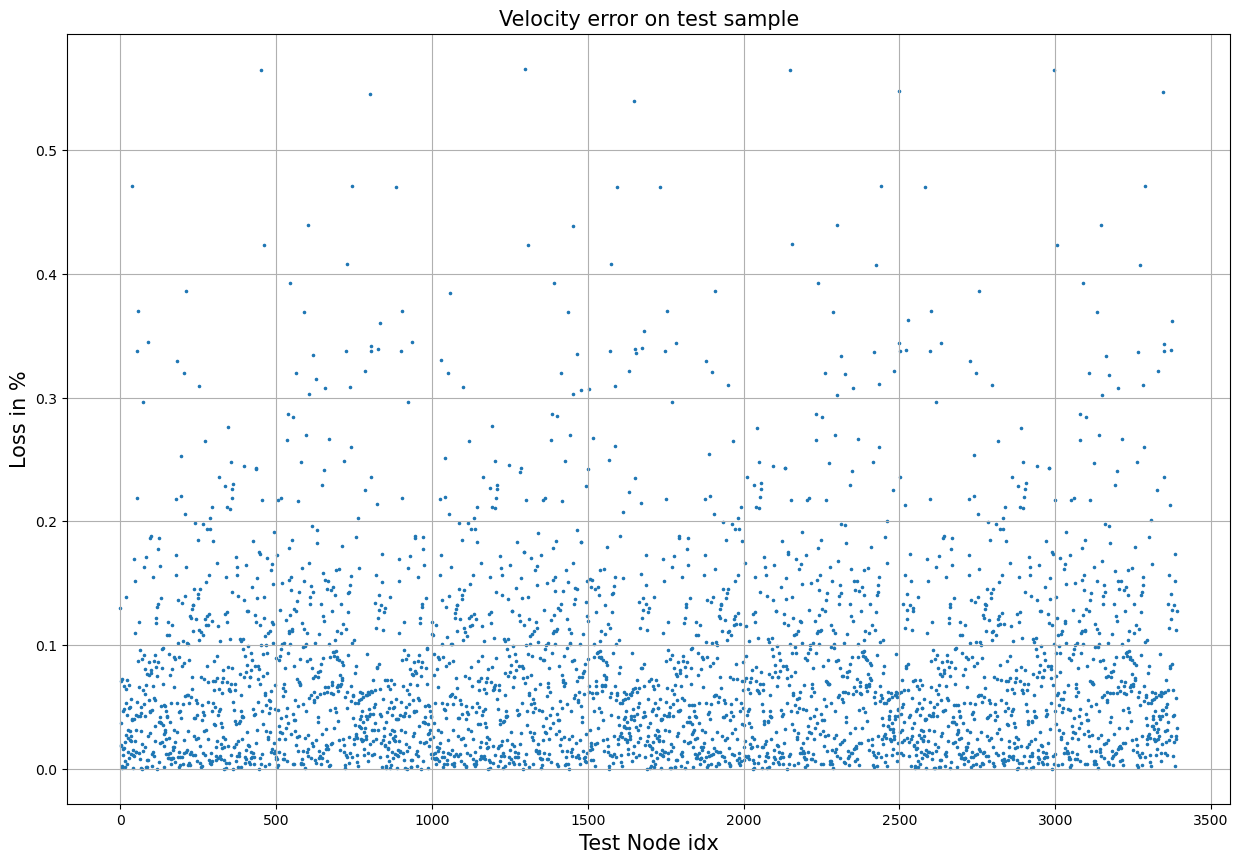

3392
3392


C:\Users\crist\AppData\Local\Temp\ipykernel_12744\2452481733.py:45: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



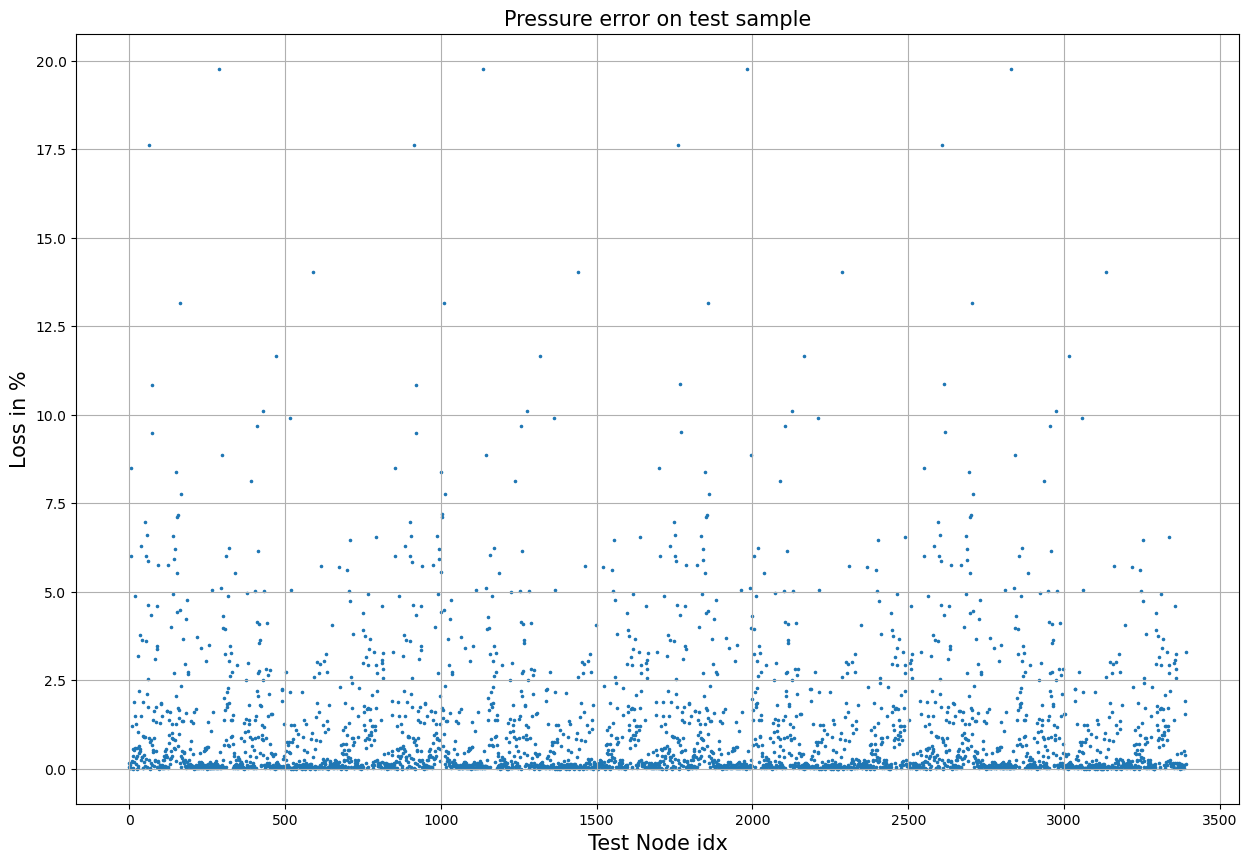

In [23]:

import matplotlib.pyplot as plt

# print(len(loss_val))

plt.figure(figsize=(15,10))

loss_velocity_flat = np.concatenate(loss_velocity)
# true_mis_flat = true_mis[0] # np.concatenate(true_mis)

true_mis_flat = [1] * len(loss_velocity_flat)
print(len(loss_velocity_flat))
print(len(true_mis_flat))
color = plt.cm.hsv(np.linspace(0, 1, len(true_mis_flat)))
# color = np.arange(len(loss_velocity))
plt.scatter(range(len(loss_velocity_flat)), loss_velocity_flat, marker = ".", c = None, cmap = 'hsv', s = 10)
# plt.colorbar()

# for i in range(len(loss_vel_z)):
#     plt.text(true_mis[i], loss_vel_z[i], str(i), fontsize=4, ha='right')

plt.title("Velocity error on test sample", size= 15)
plt.xlabel("Test Node idx", size=15)
plt.ylabel("Loss in %", size=15)
# plt.semilogy()
plt.grid()

velocity_plot_path = "velocity_error.png"
plt.savefig(velocity_plot_path)
try:
    wandb.log({"Velocity Error Plot": wandb.Image(velocity_plot_path)})
except:
    pass

plt.show()


plt.figure(figsize=(15,10))

loss_pressure_flat = np.concatenate(loss_pressure)
print(len(loss_pressure_flat))
print(len(true_mis_flat))
# color = np.arange(len(loss_press))
color = plt.cm.hsv(np.linspace(0, 1, len(true_mis_flat)))
# color = np.arange(len(loss_pressure))
plt.scatter(range(len(loss_velocity_flat)), loss_pressure_flat, marker = ".", c = None, cmap = 'hsv', s = 10)
# plt.colorbar()

# for i in range(len(loss_vel_z)):
#     plt.text(true_mis[i], loss_vel_z[i], str(i), fontsize=4, ha='right')

plt.title("Pressure error on test sample", size= 15)
plt.xlabel("Test Node idx", size=15)
plt.ylabel("Loss in %", size=15)
# plt.semilogy()
plt.grid()

pressure_plot_path = "pressure_error.png"
plt.savefig(pressure_plot_path)
try:
    wandb.log({"Pressure Error Plot": wandb.Image(pressure_plot_path)})
except:
    pass

plt.show()


In [24]:
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
train/batch_train_loss,█▄▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/samples,▁▂▃▃▄▅▆▆▇█
train/train_loss,█▃▂▂▂▂▂▁▁▁
val/val_loss,█▅▅▄▅▄▄▁▁▁
epoch,10
train/batch_train_loss,0.00447
train/samples,670
train/train_loss,0.00453
val/val_loss,0.00442
